# Проект: Маркетинг

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и 
планирует будущие продажи. Для оптимизации процессов необходимо выделить пользователей, 
которые готовы совершить покупку в ближайшее время.

**Цель проекта:**
 * Предсказать вероятность покупки в течение 90 дней

**Задачи:**
 * Изучить данные из всех предоставленных файлов
 * Разработать полезные признаки на основе исторических данных клиентов
 * Создать модель для классификации пользователей
 * Улучшить модель и максимизировать метрику ROC AUC
 * Выполнить тестирование

**Структура решения:**
1. Анализ данных и подготовка
   - Загрузка всех датасетов
   - EDA и визуализация
   - Правильное разделение данных по клиентам
2. Feature Engineering
   - Разработка RFM-признаков (Recency, Frequency, Monetary)
   - Анализ откликов на рассылки (CTR, конверсии)
   - Создание временных признаков и лагов
3. Моделирование
   - Препроцессинг и построение пайплайна
   - Обучение моделей и оптимизация гиперпараметров
   - Оценка качества и важности признаков
4. Тестирование и выводы

## Загрузка и изучение данных

### Загрузка библиотек

In [1]:
!pip install -U optuna

In [2]:
!pip install optuna-integration[sklearn]

In [3]:
# ОСНОВНЫЕ БИБЛИОТЕКИ
import os
import pandas as pd
import numpy as np
import optuna
import ast
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# БИБЛИОТЕКИ ДЛЯ МОДЕЛИРОВАНИЯ
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold
)
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFECV
from optuna.integration import OptunaSearchCV    
from optuna.distributions import IntDistribution, FloatDistribution
from optuna.study import MaxTrialsCallback
from optuna import TrialPruned
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE
import lightgbm as lgbm

# НАСТРОЙКА ВИЗУАЛИЗАЦИИ
#plt.style.use('seaborn-whitegrid')
#sns.set(font_scale=1.2)
#plt.rcParams['figure.figsize'] = (12, 8)

# ЛОГИРОВАНИЕ РЕЗУЛЬТАТОВ
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# КОНСТАНТЫ
RANDOM_STATE = 42
TEST_SIZE = 0.2
K_NEIGHBORS = 5

### Загрузка всех датасетов

In [4]:
# Определение путей к файлам
data_dir = 'data'

# Пути к основным файлам
messages_path = os.path.join(data_dir, 'apparel-messages.csv')
purchases_path = os.path.join(data_dir, 'apparel-purchases.csv')
target_path = os.path.join(data_dir, 'apparel-target_binary.csv')

# Загрузка основных данных с установкой правильных типов данных
messages = pd.read_csv(messages_path, parse_dates=['date', 'created_at'])
purchases = pd.read_csv(purchases_path, parse_dates=['date'])
target_df = pd.read_csv(target_path)

# Информация о загруженных данных
print(f"Загружено {len(messages):,} строк из файла сообщений")
print(f"Загружено {len(purchases):,} строк из файла покупок")
print(f"Загружено {len(target_df):,} клиентов в целевом датасете")

# Проверка успешности загрузки
if len(messages) > 0 and len(purchases) > 0 and len(target_df) > 0:
    print("Все основные файлы успешно загружены")
else:
    print("Ошибка при загрузке данных!")

Загружено 12,739,798 строк из файла сообщений
Загружено 202,208 строк из файла покупок
Загружено 49,849 клиентов в целевом датасете
Все основные файлы успешно загружены


### Обзор данных о сообщениях (apparel-messages)¶

In [5]:
# Проверка импорта
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [6]:
# Общая информация о датасете
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [7]:
# Проверка количества пропусков по каждому столбцу
messages.isnull().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [8]:
# Уникальные значения в признаке event (откликов на рассылку)
messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [9]:
# Уникальные значения в признаке 'event' (реакция на маркетинговые сообщения)
messages['event'].value_counts()

send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: event, dtype: int64

In [10]:
# Уникальные значения в признаке channel (канал передачи сообщений)
messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

In [11]:
# сохранение начального числа строк в датасете
len_messages_befor = len(messages)
print('Начальное число строк в датасете apparel_messages: ', len_messages_befor)

Начальное число строк в датасете apparel_messages:  12739798


### Обзор данных о покупках (apparel-purchases)

In [12]:
# Проверка импорта
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [13]:
# Общая информация о датасете
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


### Обзор целевой переменной

In [14]:
# Проверка импорта целевых данных
target_df.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Распределение целевой переменной:
0 (не совершит покупку): 48888 клиентов (98.07%)
1 (совершит покупку): 961 клиентов (1.93%)


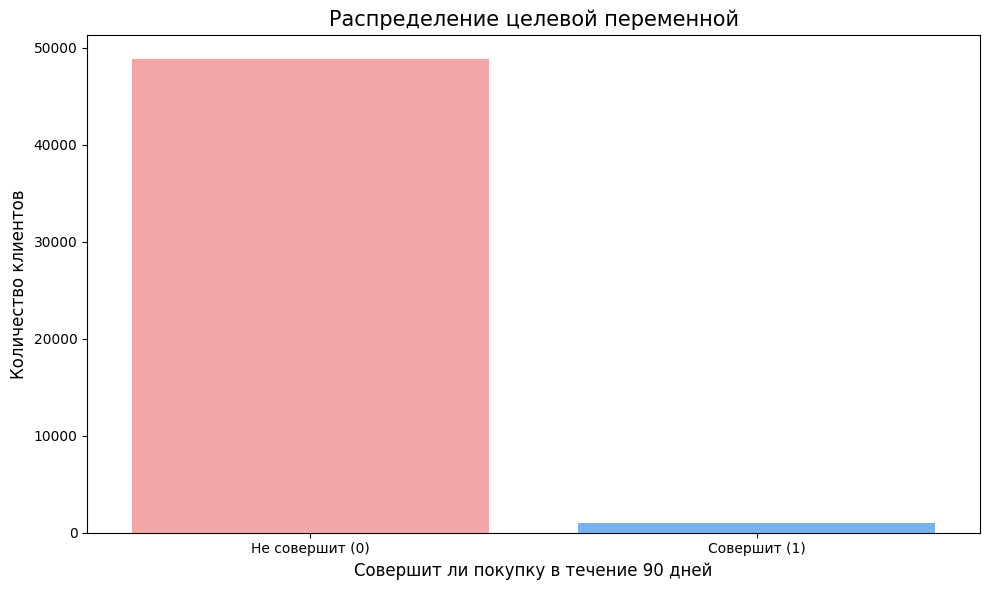

In [15]:
# Анализ распределения целевой переменной
target_counts = target_df['target'].value_counts()
target_percents = target_df['target'].value_counts(normalize=True) * 100

print(f"Распределение целевой переменной:")
print(f"0 (не совершит покупку): {target_counts[0]} клиентов ({target_percents[0]:.2f}%)")
print(f"1 (совершит покупку): {target_counts[1]} клиентов ({target_percents[1]:.2f}%)")

# Визуализация распределения
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=target_df, palette=['#FF9999', '#66B2FF'])
plt.title('Распределение целевой переменной', fontsize=15)
plt.xlabel('Совершит ли покупку в течение 90 дней', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xticks([0, 1], ['Не совершит (0)', 'Совершит (1)'])
plt.tight_layout()
plt.show()

### ВЫВОДЫ к Разделу 1

**1.** Все датафреймы импортированы, пропуски в данных не выявлены.

**2.** Выявлен значительный дисбаланс классов в целевой переменной (около 50 к 1). Необходмо рассмотреть возможность применения при машинном обучении процедур **Oversampling (SMOTE, ADASYN, BorderlineSMOTE).**

## Разделение данных

Разделение произведено **по клиентам**.

Порядок разделения:
1. Разделение клиентов (из целевого датасета) на обучающую и тестовую группы
2. Для каждой группы берется полная историю из таблиц сообщений и покупок

### Разделение клиентов на обучающую и тестовую выборки

In [16]:
# logger.info("Разделение данных датасета messages на обучающую и тестовую выборки...")
logger.info("Разделение клиентов на обучающую и тестовую выборки...")

# Разделяем КЛИЕНТОВ на обучающую и тестовую группы со стратификацией по целевой переменной
train_clients, test_clients = train_test_split(
    target_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=target_df['target']
)

# Вывод информации о размерах выборок
print(f"Разделение клиентов:")
print(f"Обучающая выборка: {len(train_clients):,} клиентов ({len(train_clients) / len(target_df) * 100:.1f}%)")
print(f"Тестовая выборка: {len(test_clients):,} клиентов ({len(test_clients) / len(target_df) * 100:.1f}%)")

# Проверка распределения целевой переменной в обеих выборках
train_target_dist = train_clients['target'].value_counts(normalize=True) * 100
test_target_dist = test_clients['target'].value_counts(normalize=True) * 100

print("\nРаспределение целевой переменной:")
print(f"Обучающая выборка: 0 - {train_target_dist[0]:.2f}%, 1 - {train_target_dist[1]:.2f}%")
print(f"Тестовая выборка: 0 - {test_target_dist[0]:.2f}%, 1 - {test_target_dist[1]:.2f}%")

2025-07-18 00:46:51,033 - INFO - Разделение клиентов на обучающую и тестовую выборки...


Разделение клиентов:
Обучающая выборка: 39,879 клиентов (80.0%)
Тестовая выборка: 9,970 клиентов (20.0%)

Распределение целевой переменной:
Обучающая выборка: 0 - 98.07%, 1 - 1.93%
Тестовая выборка: 0 - 98.07%, 1 - 1.93%


### Формирование обучающих и тестовых данных по истории клиентов

In [17]:
# logger.info("Разделение данных датасета messages на обучающую и тестовую выборки...")
logger.info("Формирование обучающих и тестовых данных на основе разделения клиентов...")

# Извлечение списков ID клиентов для обучающей и тестовой выборок
train_client_ids = train_clients['client_id'].tolist()
test_client_ids = test_clients['client_id'].tolist()

# Формирование обучающих и тестовых данных по истории сообщений
train_messages = messages[messages['client_id'].isin(train_client_ids)]
test_messages = messages[messages['client_id'].isin(test_client_ids)]

# Формируем обучающих и тестовых данных по истории покупок
train_purchases = purchases[purchases['client_id'].isin(train_client_ids)]
test_purchases = purchases[purchases['client_id'].isin(test_client_ids)]

# Вывод информации о размерах полученных выборок
print(f"Сообщения (messages):")
print(f"Обучающая выборка: {len(train_messages):,} записей ({len(train_messages) / len(messages) * 100:.1f}%)")
print(f"Тестовая выборка: {len(test_messages):,} записей ({len(test_messages) / len(messages) * 100:.1f}%)")

print(f"\nПокупки (purchases):")
print(f"Обучающая выборка: {len(train_purchases):,} записей ({len(train_purchases) / len(purchases) * 100:.1f}%)")
print(f"Тестовая выборка: {len(test_purchases):,} записей ({len(test_purchases) / len(purchases) * 100:.1f}%)")

# Проверка целостности разделения (нет ли пересечения клиентов между выборками)
assert len(set(train_client_ids).intersection(set(test_client_ids))) == 0, "Ошибка! Есть пересечение между клиентами обучающей и тестовой выборок"
logger.info("Разделение данных выполнено успешно. Пересечений между выборками нет.")

2025-07-18 00:46:51,082 - INFO - Формирование обучающих и тестовых данных на основе разделения клиентов...
2025-07-18 00:46:52,181 - INFO - Разделение данных выполнено успешно. Пересечений между выборками нет.


Сообщения (messages):
Обучающая выборка: 8,772,579 записей (68.9%)
Тестовая выборка: 2,178,342 записей (17.1%)

Покупки (purchases):
Обучающая выборка: 161,742 записей (80.0%)
Тестовая выборка: 40,466 записей (20.0%)


## Feature Engineering

Для решения задачи предсказания покупок в течение 90 дней необходимо создать информативные признаки на основе исторических данных клиентов. С этой целью была создана функция, которая будет формировать признаки для каждого клиента на основе его истории сообщений и покупок.

### Функция формирования признаков по каждому клиенту

In [18]:
# В данном случае предполагается, что таргет рассчитан для периода 90 дней после конкретной даты
# Нахождение минимальной даты из целевого датасета, т.к. она предположительно является точкой отсчета
target_min_date = min(purchases['date']) # Дата, с которой начинаются данные
logger.info(f"Минимальная дата в данных: {target_min_date.date()}")

# Нахождение общей максимальной даты во всех данных
max_message_date = messages["date"].max()
max_purchase_date = purchases["date"].max()
ABSOLUTE_MAX_DATE = max(max_message_date, max_purchase_date)

# CUTOFF_DATE - дата, ЗА 90 дней ДО конца всего периода наблюдений.
# Дата, от которой предсказывается будущее (90 дней)
CUTOFF_DATE = ABSOLUTE_MAX_DATE - timedelta(days=90)

logger.info(f"Абсолютная максимальная дата в данных: {ABSOLUTE_MAX_DATE.date()}")
logger.info(f"Корректно выведенная дата среза (CUTOFF_DATE): {CUTOFF_DATE.date()}")

# ЛОГИКА ОПРЕДЕЛЕНИЯ ТОП-КАТЕГОРИЙ (ТОЛЬКО НА ОСНОВЕ ОБУЧАЮЩЕЙ ВЫБОРКИ)
# Фильтрование данных о покупках до даты среза
train_purchases_filtered = train_purchases[train_purchases['date'] <= CUTOFF_DATE].copy()

# Преобразование строковых представлений категорий в списки
train_purchases_filtered['category_ids'] = train_purchases_filtered['category_ids'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Разворачивание списков категорий для анализа
categories_exploded_train = train_purchases_filtered.explode('category_ids')
categories_exploded_train = categories_exploded_train[
    categories_exploded_train['category_ids'].notna() & 
    (categories_exploded_train['category_ids'] != '')
]

if len(categories_exploded_train) > 0:
    # Определение топа-20 категорий ТОЛЬКО на основе обучающей выборки
    TOP_CATEGORIES = categories_exploded_train['category_ids'].value_counts().nlargest(20).index.tolist()
    logger.info(f"Определены топ-20 категорий на основе ТОЛЬКО обучающих данных: {TOP_CATEGORIES}")
else:
    TOP_CATEGORIES = []
    logger.warning("Не удалось определить топ-категории из обучающей выборки!")

print(f"Топ-20 категорий, определенные ТОЛЬКО на обучающей выборке: {TOP_CATEGORIES}")
print(f"Количество записей о покупках до даты среза: {len(train_purchases_filtered)}")

2025-07-18 00:46:52,568 - INFO - Минимальная дата в данных: 2022-05-16
2025-07-18 00:46:52,611 - INFO - Абсолютная максимальная дата в данных: 2024-02-16
2025-07-18 00:46:52,612 - INFO - Корректно выведенная дата среза (CUTOFF_DATE): 2023-11-18
2025-07-18 00:46:54,696 - INFO - Определены топ-20 категорий на основе ТОЛЬКО обучающих данных: ['4', '28', '5562', '2', '18', '27', '5630', '57', '431', '31', '260', '275', '5631', '62', '432', '244', '258', '420', '6060', '5633']


Топ-20 категорий, определенные ТОЛЬКО на обучающей выборке: ['4', '28', '5562', '2', '18', '27', '5630', '57', '431', '31', '260', '275', '5631', '62', '432', '244', '258', '420', '6060', '5633']
Количество записей о покупках до даты среза: 143538


In [19]:
# Определение "мастер-списков" ТОЛЬКО на основе ВСЕХ обучающих данных
# для определения всех возможных значений, которые могут встретиться
ALL_EVENT_TYPES = train_messages["event"].unique().tolist()
ALL_CHANNELS = train_messages["channel"].unique().tolist()

print(f"Все возможные типы событий (из обучающей выборки): {ALL_EVENT_TYPES}")
print(f"Все возможные каналы (из обучающей выборки): {ALL_CHANNELS}")

Все возможные типы событий (из обучающей выборки): ['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam', 'hard_bounce', 'soft_bounce', 'subscribe', 'complain', 'close']
Все возможные каналы (из обучающей выборки): ['email', 'mobile_push']


In [20]:
def create_client_features(
    messages_df,
    purchases_df,
    client_ids_df,
    cutoff_date,
    top_categories_list,
    all_event_types,
    all_channel_types,
):
    """
    Создает агрегированные признаки для каждого клиента

    Параметры:
    ----------
    messages_df : pd.DataFrame
        Датафрейм с историей сообщений
    purchases_df : pd.DataFrame
        Датафрейм с историей покупок
    client_ids_df : pd.DataFrame
        Датафрейм с ID клиентов и целевой переменной
    cutoff_date : datetime
        Дата среза для расчета признаков (ДОЛЖНА быть перед началом целевого периода)
    top_categories_list : list
        Список топ-категорий, определенный ТОЛЬКО на обучающих данных
    all_event_types: list
        Мастер-список всех типов событий, определенный на обучающей выборке
    all_channel_types: list
        Мастер-список всех каналов, определенный на обучающей выборке

    Возвращает:
    -----------
    pd.DataFrame
        Датафрейм с признаками для каждого клиента
    """
    logger.info(f"Создание признаков для {len(client_ids_df)} клиентов с датой среза {cutoff_date.date()}...")
    
    # Получение списка ID клиентов
    client_ids = client_ids_df['client_id'].tolist()
    
    # Создание пустого датафрейма для признаков
    features = pd.DataFrame(index=client_ids)
    features.index.name = 'client_id'
    
    # Фильтрация данных по клиентам и до даты среза
    client_messages = messages_df[messages_df['client_id'].isin(client_ids)].copy()
    client_messages = client_messages[client_messages['date'] <= cutoff_date]
    
    client_purchases = purchases_df[purchases_df['client_id'].isin(client_ids)].copy()
    client_purchases = client_purchases[client_purchases['date'] <= cutoff_date]
    
    # Определение временных окон для динамических агрегаций (в днях)
    time_windows = [7, 30, 90, 180]
    
    # 1. ПРИЗНАКИ НА ОСНОВЕ СООБЩЕНИЙ
    if len(client_messages) > 0:
        # 1.1 Частота событий (из всех возможных типов событий)
        # Использование всех типов событий, которые есть в обучающих данных
        event_counts = client_messages.groupby('client_id')['event'].value_counts().unstack(fill_value=0)
        event_counts = event_counts.reindex(columns=all_event_types, fill_value=0)
        event_counts.columns = [f'event_{col}_count' for col in event_counts.columns]
        
        # 1.2 Показатели эффективности коммуникаций
        event_counts['total_messages'] = event_counts.sum(axis=1)
        
        # Вычисление метрик
        send_count_col = 'event_send_count'
        open_count_col = 'event_open_count'
        click_count_col = 'event_click_count'
        purchase_count_col = 'event_purchase_count'
        
        # Расчет метрик (с обработкой деления на ноль)
        if send_count_col in event_counts.columns:
            event_counts['open_rate'] = event_counts.get(open_count_col, 0) / event_counts[send_count_col].replace(0, np.nan)
        if open_count_col in event_counts.columns:
            event_counts['click_through_rate'] = event_counts.get(click_count_col, 0) / event_counts[open_count_col].replace(0, np.nan)
        if click_count_col in event_counts.columns:
            event_counts['conversion_rate'] = event_counts.get(purchase_count_col, 0) / event_counts[click_count_col].replace(0, np.nan)
        
        # 1.3 Каналы коммуникации
        channel_counts = client_messages.groupby(['client_id', 'channel']).size().unstack(fill_value=0)
        channel_counts = channel_counts.reindex(columns=all_channel_types, fill_value=0)
        channel_counts.columns = [f'channel_{col}_count' for col in channel_counts.columns]
        
        # 1.4 Recency для сообщений (с использованием явной даты среза)
        message_recency = client_messages.groupby('client_id')['date'].max()
        message_recency = (cutoff_date - message_recency).dt.days
        message_recency.name = 'days_since_last_message'
        
        # 1.5 Количество уникальных кампаний
        campaign_counts = client_messages.groupby('client_id')['bulk_campaign_id'].nunique()
        campaign_counts.name = 'unique_campaigns_count'
        
        # 1.6 Динамические временные признаки для сообщений ***
        time_window_features = pd.DataFrame(index=client_ids)
        
        for window in time_windows:
            window_date = cutoff_date - timedelta(days=window)
            window_messages = client_messages[client_messages['date'] > window_date]
            
            if len(window_messages) > 0:
                # Количество сообщений за период
                messages_count = window_messages.groupby('client_id').size()
                messages_count.name = f'messages_{window}d_count'
                time_window_features = time_window_features.join(messages_count, how='left')
                
                # Метрики открытия и кликов за период
                window_events = window_messages.groupby(['client_id', 'event']).size().unstack(fill_value=0)
                if 'send' in window_events.columns:
                    time_window_features[f'send_{window}d_count'] = window_events['send'].reindex(client_ids, fill_value=0)
                if 'open' in window_events.columns:
                    time_window_features[f'open_{window}d_count'] = window_events['open'].reindex(client_ids, fill_value=0)
                if 'click' in window_events.columns:
                    time_window_features[f'click_{window}d_count'] = window_events['click'].reindex(client_ids, fill_value=0)
                
                # Вычисление метрик вовлеченности за период
                if all(col in window_events.columns for col in ['send', 'open']):
                    time_window_features[f'open_rate_{window}d'] = window_events['open'] / window_events['send'].replace(0, np.nan)
                if all(col in window_events.columns for col in ['open', 'click']):
                    time_window_features[f'ctr_{window}d'] = window_events['click'] / window_events['open'].replace(0, np.nan)
        
        # 1.7 Тренды активности по сообщениям ***
        if 'messages_30d_count' in time_window_features.columns and 'messages_90d_count' in time_window_features.columns:
            # Тренд сообщений: сравнение последних 30 дней с предыдущими 60 днями (в среднем за день)
            time_window_features['messages_trend_30_90'] = (
                time_window_features['messages_30d_count'] / 30
            ) / (
                (time_window_features['messages_90d_count'] - time_window_features['messages_30d_count']) / 60 + 0.001
            )
            
        if 'open_rate_30d' in time_window_features.columns and 'open_rate_90d' in time_window_features.columns:
            # Тренд open_rate: сравнение последних 30 дней с общим показателем за 90 дней
            time_window_features['open_rate_trend'] = time_window_features['open_rate_30d'] / time_window_features['open_rate_90d'].replace(0, np.nan)
                
        # Объединение всех признаков из сообщений
        messages_features = pd.concat([
            event_counts,
            channel_counts,
            message_recency,
            campaign_counts,
            time_window_features
        ], axis=1)
        
        features = features.join(messages_features, how='left')
    
    # 2. ПРИЗНАКИ НА ОСНОВЕ ПОКУПОК (RFM)
    if len(client_purchases) > 0:
        # Подготовка данных о категориях
        client_purchases['category_ids'] = client_purchases['category_ids'].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else []
        )
        
        # 2.1 Recency - как давно клиент совершал покупку (относительно даты среза)
        purchase_dates = client_purchases.groupby('client_id')['date'].agg(['min', 'max'])
        # Использоание явно переданной даты среза
        purchase_dates['recency_days'] = (cutoff_date - purchase_dates['max']).dt.days
        purchase_dates['customer_age_days'] = (cutoff_date - purchase_dates['min']).dt.days
        purchase_dates['purchase_span_days'] = (purchase_dates['max'] - purchase_dates['min']).dt.days
        purchase_dates = purchase_dates.drop(columns=['min', 'max'])
        
        # 2.2 Frequency - как часто клиент совершает покупки
        frequency_features = client_purchases.groupby('client_id').agg(
            total_purchases=('message_id', 'count'),
            unique_days=('date', 'nunique')
        )
        # Вычисление частоты покупок
        frequency_features['purchase_frequency'] = frequency_features['total_purchases'] / frequency_features['unique_days'].replace(0, np.nan)
        frequency_features['purchase_frequency'] = frequency_features['purchase_frequency'].fillna(0)
        
        # 2.3 Monetary - сколько денег тратит клиент
        monetary_features = client_purchases.groupby('client_id').agg(
            total_spent=('price', 'sum'),
            avg_price=('price', 'mean'),
            max_price=('price', 'max'),
            total_quantity=('quantity', 'sum'),
            avg_quantity=('quantity', 'mean')
        )
        # Вычисление средней стоимости заказа
        monetary_features['avg_order_value'] = monetary_features['total_spent'] / frequency_features['total_purchases'].replace(0, np.nan)
        monetary_features["avg_order_value"] = monetary_features[
            "avg_order_value"
        ].fillna(0)
        
        # 2.4 Категории - ИСПОЛЬЗОВАНИЕ ПРЕДВАРИТЕЛЬНО ОПРЕДЕЛЕННЫХ ТОП-КАТЕГОРИИ
        # Список категорий в длинный формат
        categories_exploded = client_purchases.explode('category_ids')[['client_id', 'category_ids']]
        categories_exploded = categories_exploded[categories_exploded['category_ids'].notna() & 
                                               (categories_exploded['category_ids'] != '')]
        
        if len(categories_exploded) > 0 and len(top_categories_list) > 0:
            # Создание признаков для переданных топ-категорий
            category_dummies = pd.crosstab(
                categories_exploded['client_id'], 
                categories_exploded['category_ids'],
                dropna=False
            )
            
            # Выделение топ-категорий, определенных на обучающей выборке
            category_dummies = category_dummies.reindex(columns=top_categories_list, fill_value=0)
            category_dummies.columns = [f'purchased_cat_{cat}' for cat in category_dummies.columns]
            
            # Сохранение общего количества уникальных категорий для каждого клиента
            unique_categories_count = categories_exploded.groupby('client_id')['category_ids'].nunique()
            unique_categories_count.name = 'unique_categories_count'
            
            # Добавление в общий датафрейм признаков
            category_features = pd.concat([category_dummies, unique_categories_count], axis=1)
        else:
            # Если нет данных о категориях или топ-категорий, создается пустой датафрейм с нулями
            category_features = pd.DataFrame(index=client_purchases['client_id'].unique())
            # Добавление колонок для всех топ-категорий со значением 0
            for cat in top_categories_list:
                category_features[f'purchased_cat_{cat}'] = 0
            category_features['unique_categories_count'] = 0
        
        # Объединение всех признаков из покупок
        purchase_features = pd.concat([
            purchase_dates,
            frequency_features,
            monetary_features,
            category_features
        ], axis=1)
        
        features = features.join(purchase_features, how='left')
    
    # 3. Дополнительные признаки и обработка пропусков
    
    # 3.1 Соотношение покупок к сообщениям
    if 'total_purchases' in features.columns and 'total_messages' in features.columns:
        features['purchase_per_message_ratio'] = features['total_purchases'] / features['total_messages'].replace(0, np.nan)
        features["purchase_per_message_ratio"] = features[
            "purchase_per_message_ratio"
        ].fillna(0)
    
    # 3.2 Заполнение всех оставшихся пропусков нулями (для клиентов без истории)
    features = features.fillna(0)
    
    # Добавление client_id и target
    features = features.reset_index()
    features = features.merge(client_ids_df[['client_id', 'target']], on='client_id', how='left')
    
    logger.info(f"Создано {features.shape[1] - 2} признака для {features.shape[0]} клиентов")
    
    return features

In [21]:
# Проверка функции на небольшом подмножестве данных
test_client_sample = train_clients.iloc[:5]  # берем 5 клиентов для теста

sample_features = create_client_features(
    messages, 
    purchases, 
    test_client_sample, 
    CUTOFF_DATE, 
    TOP_CATEGORIES,
    ALL_EVENT_TYPES,
    ALL_CHANNELS
)

print(f"Пример создания признаков (первые 5 клиентов):")
print(f"Размерность: {sample_features.shape}")
print(f"Столбцы: {sample_features.columns.tolist()[:10]}...")
sample_features.head()

2025-07-18 00:46:55,414 - INFO - Создание признаков для 5 клиентов с датой среза 2023-11-18...
2025-07-18 00:46:55,565 - INFO - Создано 79 признака для 5 клиентов


Пример создания признаков (первые 5 клиентов):
Размерность: (5, 81)
Столбцы: ['client_id', 'event_open_count', 'event_click_count', 'event_purchase_count', 'event_send_count', 'event_unsubscribe_count', 'event_hbq_spam_count', 'event_hard_bounce_count', 'event_soft_bounce_count', 'event_subscribe_count']...


,client_id,event_open_count,event_click_count,event_purchase_count,event_send_count,event_unsubscribe_count,event_hbq_spam_count,event_hard_bounce_count,event_soft_bounce_count,event_subscribe_count,...,purchased_cat_62,purchased_cat_432,purchased_cat_244,purchased_cat_258,purchased_cat_420,purchased_cat_6060,purchased_cat_5633,unique_categories_count,purchase_per_message_ratio,target
0,1515915626002185192,5,0,0,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
1,1515915625771548405,50,45,3,56,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.019481,0
2,1515915625491836496,10,5,1,141,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.012739,0
3,1515915625559477131,5,1,1,59,0,0,0,0,0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.030303,0
4,1515915625500413669,11,4,1,214,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.004348,0


### Создание обучающего и тестового наборов данных с признаками

При использовании функции **create_client_features** для создания признаков без утечки данных:

1. Применена фиксированная дата среза (CUTOFF_DATE)
2. Определены топ-категории ТОЛЬКО на основе обучающей выборки (TOP_CATEGORIES)
3. Одинаковая трансформация для обучающей и тестовой выборок

In [22]:
# Создание полного набора признаков с использованием корректной даты среза
print(f"Используем дату среза: {CUTOFF_DATE.date()} для создания признаков")

# Создание полного набора признаков для обучающей выборки
X_train = create_client_features(
    train_messages,
    train_purchases,
    train_clients,
    CUTOFF_DATE,
    TOP_CATEGORIES,
    ALL_EVENT_TYPES,
    ALL_CHANNELS
)

# Создание полного набора признаков для тестовой выборки
# Использование тех же TOP_CATEGORIES, что были определены на обучающей выборке!
X_test = create_client_features(
    test_messages,
    test_purchases,
    test_clients,
    CUTOFF_DATE,
    TOP_CATEGORIES,
    ALL_EVENT_TYPES,
    ALL_CHANNELS
)

# Выделение целевой переменной и ID клиентов
y_train = X_train.pop('target')
y_test = X_test.pop('target')

# Сохранение client_id для последующего анализа
train_client_ids_df = X_train[['client_id']]
test_client_ids_df = X_test[['client_id']]

# Удаление client_id из признаков
X_train_processed = X_train.drop(columns=['client_id'])
X_test_processed = X_test.drop(columns=['client_id'])

# Информация о размерности данных
print(f"Обучающая выборка: {X_train_processed.shape[0]} клиентов, {X_train_processed.shape[1]} признака")
print(f"Тестовая выборка: {X_test_processed.shape[0]} клиентов, {X_test_processed.shape[1]} признака")

# Проверка идентичности наборов признаков
assert set(X_train_processed.columns) == set(X_test_processed.columns), "Ошибка! Наборы признаков не совпадают!"
print(f"Проверка пройдена: наборы признаков идентичны. Всего признаков: {len(X_train_processed.columns)}")

# Проверка наличия топ-категориальных признаков
cat_features = [col for col in X_train_processed.columns if col.startswith('purchased_cat_')]
print(f"\nСозданы признаки по категориям ({len(cat_features)}):")
print(cat_features[:5], "..." if len(cat_features) > 5 else "")

2025-07-18 00:46:55,590 - INFO - Создание признаков для 39879 клиентов с датой среза 2023-11-18...


Используем дату среза: 2023-11-18 для создания признаков


2025-07-18 00:47:17,038 - INFO - Создано 79 признака для 39879 клиентов
2025-07-18 00:47:17,243 - INFO - Создание признаков для 9970 клиентов с датой среза 2023-11-18...
2025-07-18 00:47:20,665 - INFO - Создано 79 признака для 9970 клиентов


Обучающая выборка: 39879 клиентов, 79 признака
Тестовая выборка: 9970 клиентов, 79 признака
Проверка пройдена: наборы признаков идентичны. Всего признаков: 79

Созданы признаки по категориям (20):
['purchased_cat_4', 'purchased_cat_28', 'purchased_cat_5562', 'purchased_cat_2', 'purchased_cat_18'] ...


In [23]:
# Приведение в соответствие типов данных выборки X_train_processed
# для экономии памяти и ускорения рассчетов

# Список исключений
exclude_cols = ['purchase_per_message_ratio', 'avg_price', 'avg_quantity', 
                'avg_order_value', 'open_rate', 'click_through_rate', 
                'conversion_rate', 'purchase_frequency', 
                'open_rate_7d', 'ctr_7d',
                'open_rate_30d', 'ctr_30d', 
                'open_rate_90d', 'ctr_90d',
                'open_rate_180d', 'ctr_180d', 
                'messages_trend_30_90', 
                'open_rate_trend'
               ]

# Определение всех float64-колонок, которые не входят в список исключений
cols_to_convert = [
    col for col in X_train_processed.select_dtypes(include='float64').columns
    if col not in exclude_cols
]

# Проверка, что значения целые, и только после этого преобразование
for col in cols_to_convert:
    if (X_train_processed[col] % 1 == 0).all():  # Все значения целые
        X_train_processed[col] = X_train_processed[col].astype('int32')
    else:
        print(f'Пропущено в выборке X_train_processed: {col} содержит дробные значения')
        
# Приведение в соответствие типов данных выборки X_test_processed
# Определение всех float64-колонок, которые не входят в список исключений
cols_to_convert = [
    col for col in X_test_processed.select_dtypes(include='float64').columns
    if col not in exclude_cols
]

# Проверка, что значения целые, и только после этого преобразование
for col in cols_to_convert:
    if (X_test_processed[col] % 1 == 0).all():  # Все значения целые
        X_test_processed[col] = X_test_processed[col].astype('int32')
    else:
        print(f'Пропущено в выборке X_test_processed: {col} содержит дробные значения')

### Анализ признаков и их связи с целевой переменной

Количество пропущенных значений в признаках:
Series([], dtype: int64)

Топ-20 признаков по корреляции с целевой переменной:
target                 1.000000
purchase_span_days     0.081873
messages_30d_count     0.071104
open_30d_count         0.069147
messages_7d_count      0.068488
click_90d_count        0.068138
click_180d_count       0.066912
open_7d_count          0.066586
click_30d_count        0.063620
open_180d_count        0.062693
open_90d_count         0.062495
open_rate_30d          0.061676
open_rate_180d         0.060594
messages_90d_count     0.060507
event_click_count      0.059891
event_open_count       0.059767
open_rate_90d          0.059152
unique_days            0.058704
messages_180d_count    0.056457
open_rate_7d           0.056136
Name: target, dtype: float64


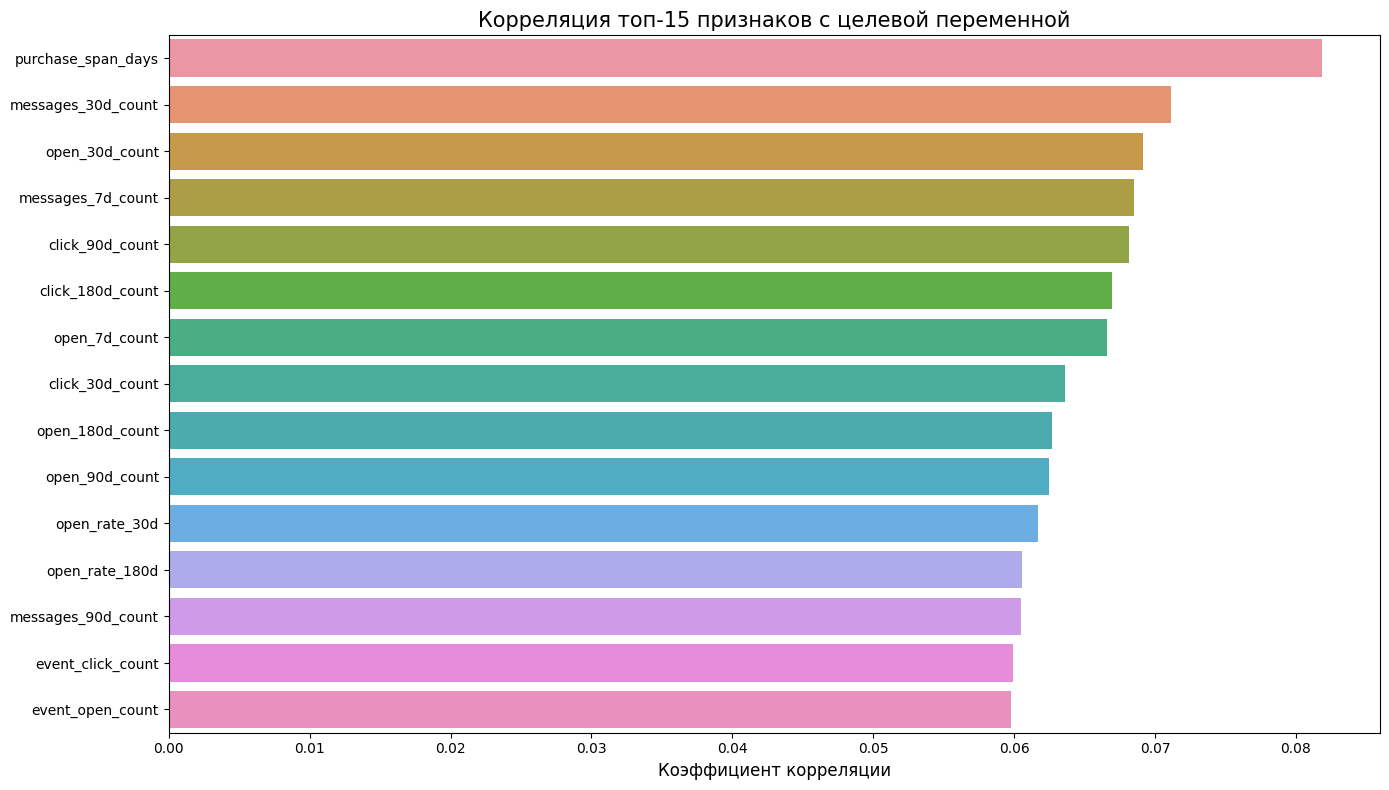

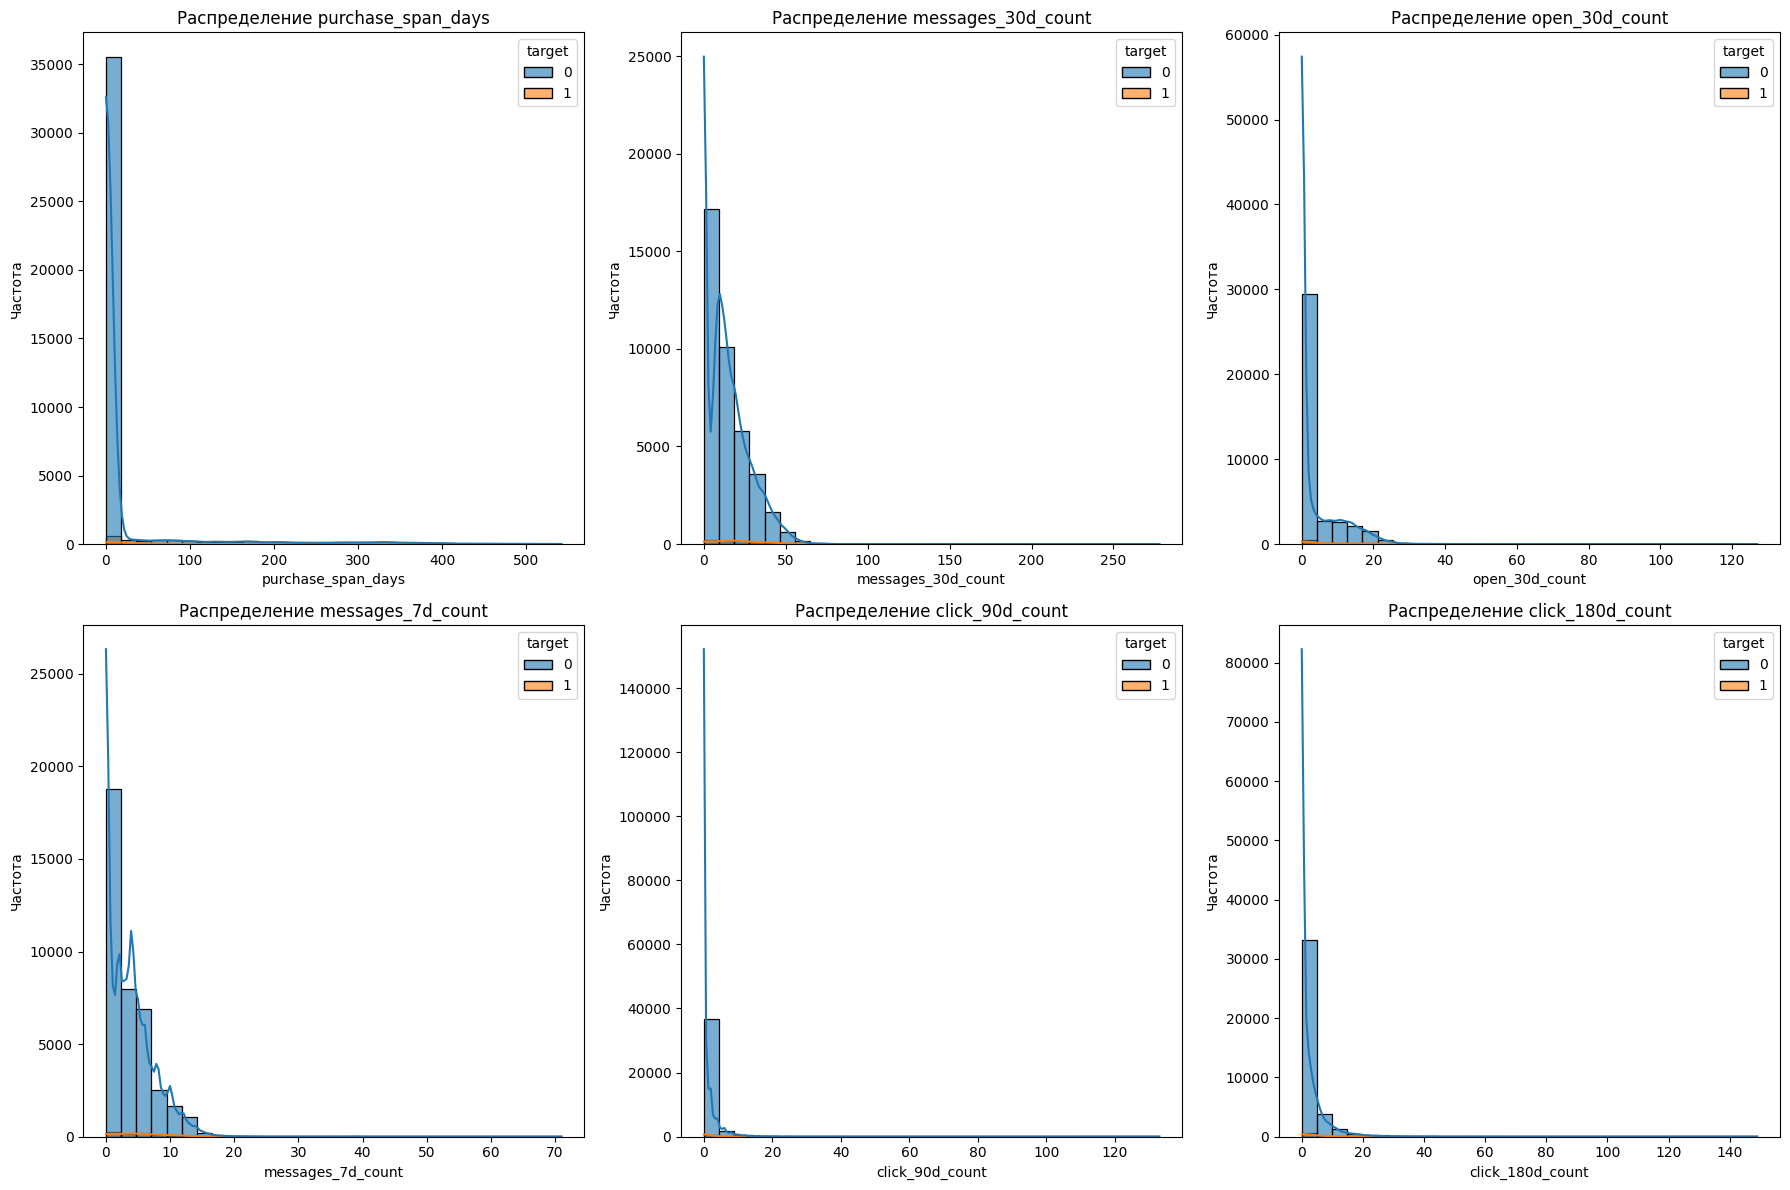

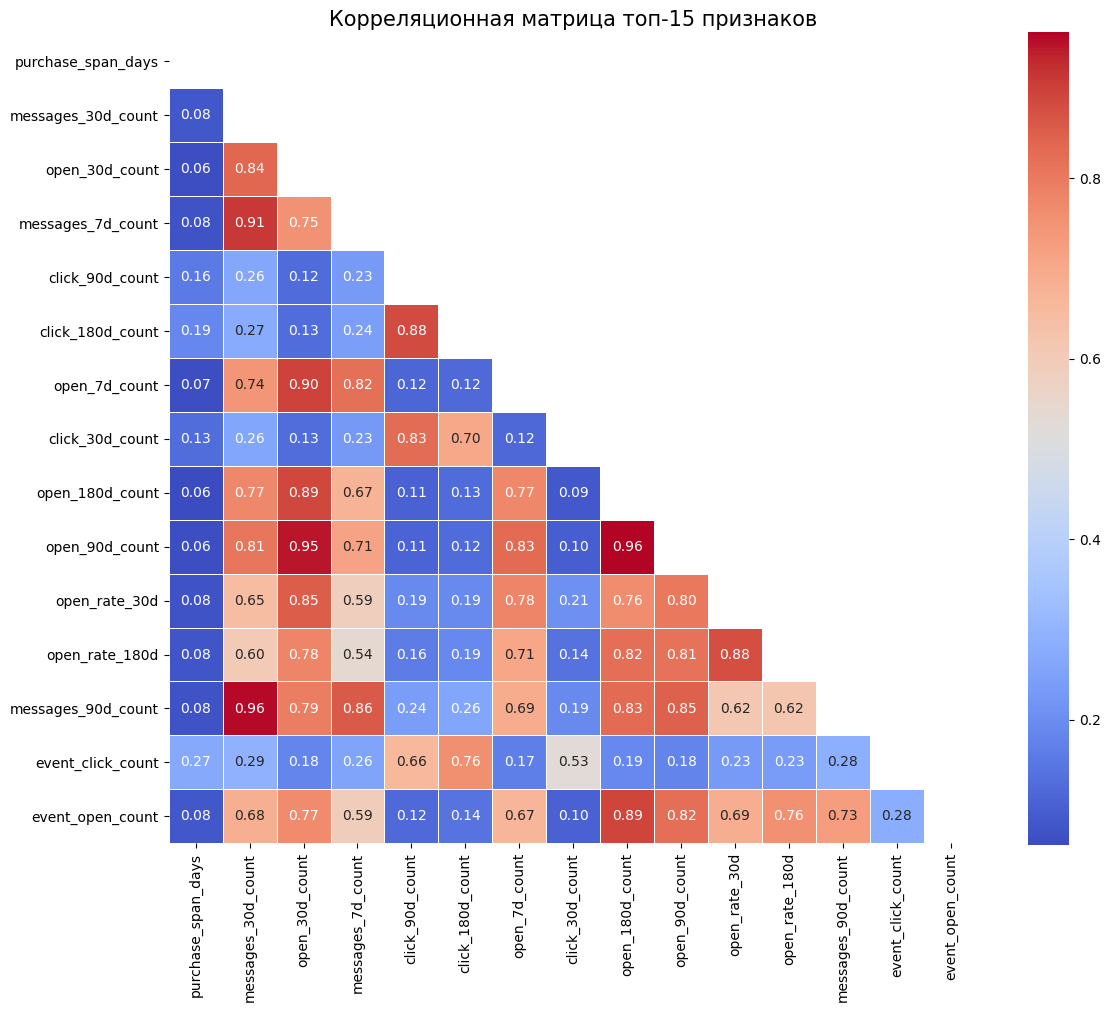

In [24]:
# Анализ пропущенных значений
missing_values = X_train_processed.isnull().sum()
print("Количество пропущенных значений в признаках:")
print(missing_values[missing_values > 0])

# Анализ корреляции признаков с целевой переменной
corr_data = X_train_processed.copy()
corr_data['target'] = y_train

# Топ-20 признаков по корреляции с целевой переменной
feature_correlations = corr_data.corr()['target'].sort_values(ascending=False)
print("\nТоп-20 признаков по корреляции с целевой переменной:")
print(feature_correlations[:20])

# Визуализация корреляций топ-15 признаков с целевой переменной
plt.figure(figsize=(14, 8))
top_features = feature_correlations.iloc[1:16].index  # Исключаем саму целевую переменную
sns.barplot(x=feature_correlations[1:16].values, y=top_features)
plt.title('Корреляция топ-15 признаков с целевой переменной', fontsize=15)
plt.xlabel('Коэффициент корреляции', fontsize=12)
plt.tight_layout()
plt.show()

# Визуализация распределения ключевых признаков
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Определение списков важных признаков для визуализации
important_features = top_features[:6]

# Построение для каждого важного признака гистограмм с разделением по целевой переменной
for i, feature in enumerate(important_features):
    if feature in X_train_processed.columns:
        sns.histplot(
            data=corr_data, 
            x=feature, 
            hue='target',
            bins=30, 
            alpha=0.6, 
            kde=True,
            ax=axes[i]
        )
        axes[i].set_title(f'Распределение {feature}', fontsize=12)
        axes[i].set_ylabel('Частота', fontsize=10)
        
plt.tight_layout()
plt.show()

# Анализ зависимостей между признаками
plt.figure(figsize=(12, 10))
correlation_matrix = X_train_processed[top_features].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix, 
    mask=mask,
    annot=True, 
    fmt=".2f",
    cmap='coolwarm', 
    square=True,
    linewidths=0.5
)
plt.title('Корреляционная матрица топ-15 признаков', fontsize=15)
plt.tight_layout()
plt.show()

### ВЫВОДЫ к Разделу 3

**1.** Мультиколлинеарность между целевой переменной и входными признаками не установлена, утечка данных отсутствует.

**2.** Топ-15 входных признаков находятся в незначительной связи с целевым.

**3.** Нормальное распределение данных в числовых признаках не выявлено.

## Базовая модель с использованием LGBMClassifier

### Пайплайн для предобработки данных

In [25]:
# Определение числовых и категориальных признаков
numeric_features = X_train_processed.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()
categorical_features = X_train_processed.select_dtypes(include=['object', 'category']).columns.tolist()

# Преобразование категориальных колонок (если они есть) X_train_processed в нужный тип для LGBM
for col in categorical_features:
    X_train_processed[col] = X_train_processed[col].astype('category')

# Преобразование категориальных колонок (если они есть) X_test_processed в нужный тип для LGBM
for col in categorical_features:
    X_test_processed[col] = X_test_processed[col].astype('category')

print(f"Числовые признаки ({len(numeric_features)}): {numeric_features[:5]}...")
print(f"Категориальные признаки ({len(categorical_features)}): {categorical_features}")

# Создание пайплайна для предобработки числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Только числовая обработка — категориальные исключается
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'  # <== Важно: чтобы категориальные не удалялись
)

print("Пайплайн предобработки данных успешно создан.")

Числовые признаки (79): ['event_open_count', 'event_click_count', 'event_purchase_count', 'event_send_count', 'event_unsubscribe_count']...
Категориальные признаки (0): []
Пайплайн предобработки данных успешно создан.


### Базовая модель LGBMClassifier, обучение и оценка качества

2025-07-18 00:47:24,920 - INFO - Обучение модели LightGBM...


[LightGBM] [Info] Number of positive: 769, number of negative: 39110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8787
[LightGBM] [Info] Number of data points in the train set: 39879, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019283 -> initscore=-3.929042
[LightGBM] [Info] Start training from score -3.929042

📊 РЕЗУЛЬТАТЫ РАСЧЕТОВ МЕТРИК ДЛЯ БАЗОВОЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ:
ROC-AUC: 0.7176
Average Precision Score: 0.0586


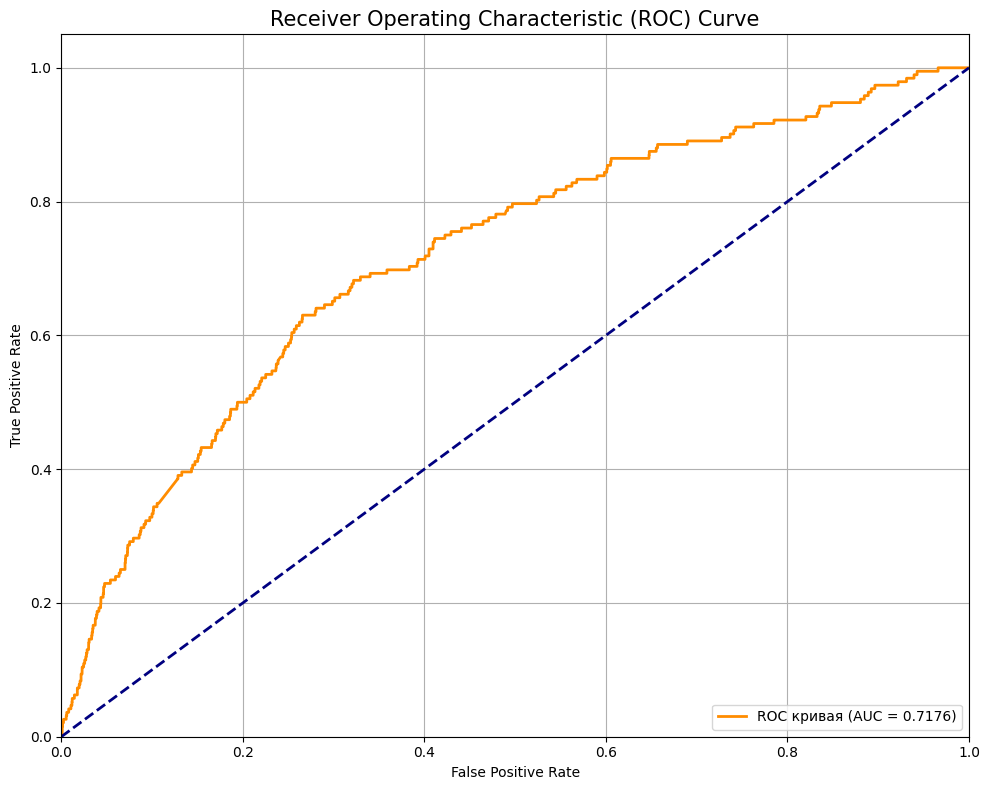

In [26]:
# Создание полного пайплайна с моделью LightGBM
lgbm_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            lgbm.LGBMClassifier(
                random_state=RANDOM_STATE
            ),
        ),
    ]
)

# Обучение модели
logger.info("Обучение модели LightGBM...")

lgbm_pipeline.fit(X_train_processed, y_train)

# Предсказание вероятностей на тестовой выборке
y_pred_proba = lgbm_pipeline.predict_proba(X_test_processed)[:, 1]

print(f"\n{'=' * 70}")
print("📊 РЕЗУЛЬТАТЫ РАСЧЕТОВ МЕТРИК ДЛЯ БАЗОВОЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print(f"{'=' * 70}")

# Расчет ROC AUC на тестовой выборке
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {test_roc_auc:.4f}")

# Расчет Average Precision Score на тестовой выборке
test_ap = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score: {test_ap:.4f}")

# Визуализация ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(
    fpr, tpr, color="darkorange", lw=2, label=f"ROC кривая (AUC = {test_roc_auc:.4f})"
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=15)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Oversampling. Сэмплирование минорного класса целевой переменной

In [27]:
# СЭМПЛИРОВАНИЕ МИНОРНОГО КЛАССА ЦЕЛЕВОГО ПРИЗНАКА (ИСПОЛЬЗОВАНИЕ ADASYN)
# экземпляр сэмплера

sampler = ADASYN(random_state=RANDOM_STATE)
# sampler = BorderlineSMOTE(random_state=RANDOM_STATE, k_neighbors=K_NEIGHBORS)

# сэмплируем данные
X_train_resample, y_train_resample = sampler.fit_resample(X_train_processed, y_train)

# Создаем полный пайплайн с моделью LightGBM
lgbm_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "classifier",
            lgbm.LGBMClassifier(
                random_state=RANDOM_STATE
            ),
        ),
    ]
)

# Обучение модели
logger.info("Обучение модели LightGBM...")

lgbm_pipeline.fit(X_train_resample, y_train_resample)

# Предсказание вероятностей на тестовой выборке
y_pred_proba_sampl = lgbm_pipeline.predict_proba(X_test_processed)[:, 1]

print(f"\n{'=' * 75}")
print('📊 РЕЗУЛЬТАТЫ РАСЧЕТОВ МЕТРИК НА ТЕСТОВОЙ ВЫБОРКЕ С ИСПОЛЬЗОВАНИЕМ ADASYN:')
print(f"{'=' * 75}")

# Расчет ROC AUC на тестовой выборке
test_roc_auc_sampl = roc_auc_score(y_test, y_pred_proba_sampl)
print(f"ROC-AUC: {test_roc_auc_sampl:.4f}")

# Расчет Average Precision Score на тестовой выборке
test_ap_sampl = average_precision_score(y_test, y_pred_proba_sampl)
print(f"Average Precision Score: {test_ap_sampl:.4f}")

2025-07-18 00:47:26,283 - INFO - Обучение модели LightGBM...


[LightGBM] [Info] Number of positive: 38948, number of negative: 39110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10306
[LightGBM] [Info] Number of data points in the train set: 78058, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498962 -> initscore=-0.004151
[LightGBM] [Info] Start training from score -0.004151

📊 РЕЗУЛЬТАТЫ РАСЧЕТОВ МЕТРИК НА ТЕСТОВОЙ ВЫБОРКЕ С ИСПОЛЬЗОВАНИЕМ ADASYN:
ROC-AUC: 0.6801
Average Precision Score: 0.0424


### ВЫВОДЫ к Разделу 4

**1.** При обучении базовой модели **LGBMClassifier(random_state=RANDOM_STATE)** и предсказании целевой переменной были получены следующие значения метрик для тестовой выборки:

* ROC-AUC: **0.7176**
* Average Precision Score: **0.0586**

**2.** Произведены процедуры семплирования по целевому признаку с помощью инструментов **SMOTE, BorderlineSMOTE и ADASYN**. Для всех данных инструментов зафиксировано снижение показателей качества базовой модели. Так, например, для **ADASYN** получены следующие значения **ROC-AUC = 0.6801 и Average-Precision-Score = 0.0424.** Данное обстоятельство, предположительно, связано с высокой степенью "перемешанности" объектов классов целевой переменной между собой, невозможностью с помощью примененных инструментов установления между классами границ классификации.

**3.** Низкий показатель метрики базовой модели **Average Precision Score (0.0586)** свидетельствует о слабой возможности различать клиентов, которые осуществлят покупки в ближайшие 90 дней (класс 1), от клиентов, которые не совершат ни одной покупки в этот период (класс 0). Модель обучена предсказывать 0 класс. Причина, как видится, состоит в малом "присутствии" данных минорного класса в обучающей выборке.

## Улучшение базовой модели

Проведена дополнительная работа для повышения предиктивной способности базовой модели:

1. Оптимизация гиперпараметров LightGBM с применением кросс-валидации тренировочной выборки
2. Рекурсивное устранение признаков с кросс-валидацией (Recursive Feature Elimination with Cross-Validation)

### Оптимизация гиперпараметров модели LGBMClassifier 

In [28]:
# Функция остановки подбора гиперпараметров, если нет улучшений на протяжении N последовательных неудачных попыток
class EarlyStoppingCallback:
    def __init__(self, patience):
        self.patience = patience
        self.best_score = None
        self.counter = 0

    def __call__(self, study, trial):
        if self.best_score is None or study.best_value > self.best_score:
            self.best_score = study.best_value
            self.counter = 0
        else:
            self.counter += 1
        if self.counter >= self.patience:
            print(f"\n[EarlyStopping] Прекращение после {self.patience} без улучшений")
            study.stop()

In [29]:
# Вычисление scale_pos_weight для решения проблемы несбалансированных классов
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Оптимальное значение scale_pos_weight для балансировки классов: {scale_pos_weight:.4f}")

# Пайплайн для LightGBM 
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('selectkbest', SelectKBest(score_func=f_classif, k=1)),
    ('classifier', lgbm.LGBMClassifier(
        random_state=RANDOM_STATE, 
        # scale_pos_weight=scale_pos_weight,  # Важный параметр для несбалансированных данных
        verbose=-1  # Отключение лишнего вывода
    ))
])

# Диапазоны параметров модели:
distributions = {
    #'selectkbest__k': IntDistribution(10, X_train_processed.shape[1]),
    # общее количество деревьев (влияет на переобучение и время)       # IntDistribution(100, 1000), 
    'classifier__n_estimators': IntDistribution(195, 195),                  
    # от очень медленного до умеренного обучения                       # FloatDistribution(0.01, 0.3),
    'classifier__learning_rate': FloatDistribution(0.038066106327261096, 0.038066106327261096),             
    # глубина дерева: от простых до сложных                            # IntDistribution(3, 50),
    'classifier__max_depth': IntDistribution(3, 3),                                     
    # больше листьев → выше точность, но выше переобучение             # IntDistribution(10, 150),
    'classifier__num_leaves': IntDistribution(102, 102),                                  
    # влияет на минимальное количество выборок в листе                 # IntDistribution(5, 50),
    'classifier__min_child_samples': IntDistribution(37, 37),                            
    # стохастичность на уровне объектов                                # FloatDistribution(0.5, 1.0),
    'classifier__subsample': FloatDistribution(0.7393709689885132, 0.7393709689885132),          
    # стохастичность на уровне признаков                               # FloatDistribution(0.5, 1.0), 
    'classifier__colsample_bytree': FloatDistribution(0.8462668449692932, 0.8462668449692932),         
    # L1-регуляризация                                                 # FloatDistribution(0.0, 5.0),
    'classifier__reg_alpha': FloatDistribution(2.9682548219311715, 2.9682548219311715),               
    # L2-регуляризация                                                 # FloatDistribution(2.0, 7.0), 
    'classifier__reg_lambda': FloatDistribution(4.162019585610067, 4.162019585610067)                          
}

# Cтратегия кросс-валидации
cv_strategy = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=RANDOM_STATE
)

# Подбор гиперпараметров
optuna_search = OptunaSearchCV(
    lgbm_pipeline,
    distributions,
    scoring='roc_auc',
    n_trials=100,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=-1,
    random_state=RANDOM_STATE,
    callbacks=[EarlyStoppingCallback(patience=3)] # при оптимизации было patience=15
)

Оптимальное значение scale_pos_weight для балансировки классов: 50.8583


In [30]:
# Обучение модели
optuna_search.fit(X_train_processed, y_train)

[I 2025-07-18 00:47:27,747] A new study created in memory with name: no-name-15e041c5-801b-42eb-9cbe-d532e3a42be2
[I 2025-07-18 00:47:40,624] Trial 5 finished with value: 0.7281320642898846 and parameters: {'classifier__n_estimators': 195, 'classifier__learning_rate': 0.038066106327261096, 'classifier__max_depth': 3, 'classifier__num_leaves': 102, 'classifier__min_child_samples': 37, 'classifier__subsample': 0.7393709689885132, 'classifier__colsample_bytree': 0.8462668449692932, 'classifier__reg_alpha': 2.9682548219311715, 'classifier__reg_lambda': 4.162019585610067}. Best is trial 5 with value: 0.7281320642898846.
[I 2025-07-18 00:47:40,637] Trial 2 finished with value: 0.7281320642898846 and parameters: {'classifier__n_estimators': 195, 'classifier__learning_rate': 0.038066106327261096, 'classifier__max_depth': 3, 'classifier__num_leaves': 102, 'classifier__min_child_samples': 37, 'classifier__subsample': 0.7393709689885132, 'classifier__colsample_bytree': 0.8462668449692932, 'classi


[EarlyStopping] Прекращение после 3 без улучшений

[EarlyStopping] Прекращение после 3 без улучшений

[EarlyStopping] Прекращение после 3 без улучшений

[EarlyStopping] Прекращение после 3 без улучшений

[EarlyStopping] Прекращение после 3 без улучшений


[I 2025-07-18 00:47:45,907] Trial 9 finished with value: 0.7281320642898846 and parameters: {'classifier__n_estimators': 195, 'classifier__learning_rate': 0.038066106327261096, 'classifier__max_depth': 3, 'classifier__num_leaves': 102, 'classifier__min_child_samples': 37, 'classifier__subsample': 0.7393709689885132, 'classifier__colsample_bytree': 0.8462668449692932, 'classifier__reg_alpha': 2.9682548219311715, 'classifier__reg_lambda': 4.162019585610067}. Best is trial 5 with value: 0.7281320642898846.
[I 2025-07-18 00:47:46,060] Trial 10 finished with value: 0.7281320642898846 and parameters: {'classifier__n_estimators': 195, 'classifier__learning_rate': 0.038066106327261096, 'classifier__max_depth': 3, 'classifier__num_leaves': 102, 'classifier__min_child_samples': 37, 'classifier__subsample': 0.7393709689885132, 'classifier__colsample_bytree': 0.8462668449692932, 'classifier__reg_alpha': 2.9682548219311715, 'classifier__reg_lambda': 4.162019585610067}. Best is trial 5 with value: 0


[EarlyStopping] Прекращение после 3 без улучшений

[EarlyStopping] Прекращение после 3 без улучшений


[I 2025-07-18 00:47:46,140] Trial 8 finished with value: 0.7281320642898846 and parameters: {'classifier__n_estimators': 195, 'classifier__learning_rate': 0.038066106327261096, 'classifier__max_depth': 3, 'classifier__num_leaves': 102, 'classifier__min_child_samples': 37, 'classifier__subsample': 0.7393709689885132, 'classifier__colsample_bytree': 0.8462668449692932, 'classifier__reg_alpha': 2.9682548219311715, 'classifier__reg_lambda': 4.162019585610067}. Best is trial 5 with value: 0.7281320642898846.



[EarlyStopping] Прекращение после 3 без улучшений


OptunaSearchCV(callbacks=[<__main__.EarlyStoppingCallback object at 0x000001D2910A7C10>],
               cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('num',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='median'))]),
                                                                           ['event_open_count',
                                                                            'event_click_cou...
                                    'classifier__reg_alpha': FloatDistribution(high=2.9682548219311715, log=False, low=2.9682548219311715, step=None),
                                    'classifier__reg_lambda': FloatDistribution(high=4.162019585610067, log=False, low=4.162019585610067, step=None),
                                    'classifier__subsample': FloatDistribution(high=0.7393709689885132, log=False, low=0.7393709689885132, step=None)},
               random_state=42, scoring='roc_auc', verbose=-1)

In [31]:
print("🏆 ПАРАМЕТРЫ ЛУЧШЕЙ МОДЕЛИ ПО ИТОГУ КРОСС-ВАЛИДАЦИИ:")
print(f"{'=' * 52}")
best_params = optuna_search.best_params_
print(best_params)

🏆 ПАРАМЕТРЫ ЛУЧШЕЙ МОДЕЛИ ПО ИТОГУ КРОСС-ВАЛИДАЦИИ:
{'classifier__n_estimators': 195, 'classifier__learning_rate': 0.038066106327261096, 'classifier__max_depth': 3, 'classifier__num_leaves': 102, 'classifier__min_child_samples': 37, 'classifier__subsample': 0.7393709689885132, 'classifier__colsample_bytree': 0.8462668449692932, 'classifier__reg_alpha': 2.9682548219311715, 'classifier__reg_lambda': 4.162019585610067}


In [32]:
roc_auc_cv = optuna_search.best_score_
print(f'Лучшая метрика на кросс-валидации ROC_AUC_CV: {roc_auc_cv:.4f}')

Лучшая метрика на кросс-валидации ROC_AUC_CV: 0.7281


In [33]:
# Лучшая модель
best_model = optuna_search.best_estimator_

# Предсказание вероятностей на тестовой выборке
y_pred_proba_optimized = best_model.predict_proba(X_test_processed)[:, 1]

print(f"\n{'=' * 68}")
print("📊 РЕЗУЛЬТАТЫ РАСЧЕТОВ МЕТРИК ДЛЯ ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print(f"{'=' * 68}")

# Расчет ROC AUC на тестовой выборке
test_roc_auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)
print(f"ROC-AUC: {test_roc_auc_optimized:.4f}")

# Расчет Average Precision Score на тестовой выборке
test_ap_optimized = average_precision_score(y_test, y_pred_proba_optimized)
print(f"Average Precision Score: {test_ap_optimized:.4f}")


📊 РЕЗУЛЬТАТЫ РАСЧЕТОВ МЕТРИК ДЛЯ ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ:
ROC-AUC: 0.7522
Average Precision Score: 0.0635


### Рекурсивное устранение признаков с кросс-валидацией (RFECV)

2025-07-18 00:47:47,044 - INFO - Подождите! Идет RFECV-поиск оптимального набора признаков...


Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 fe

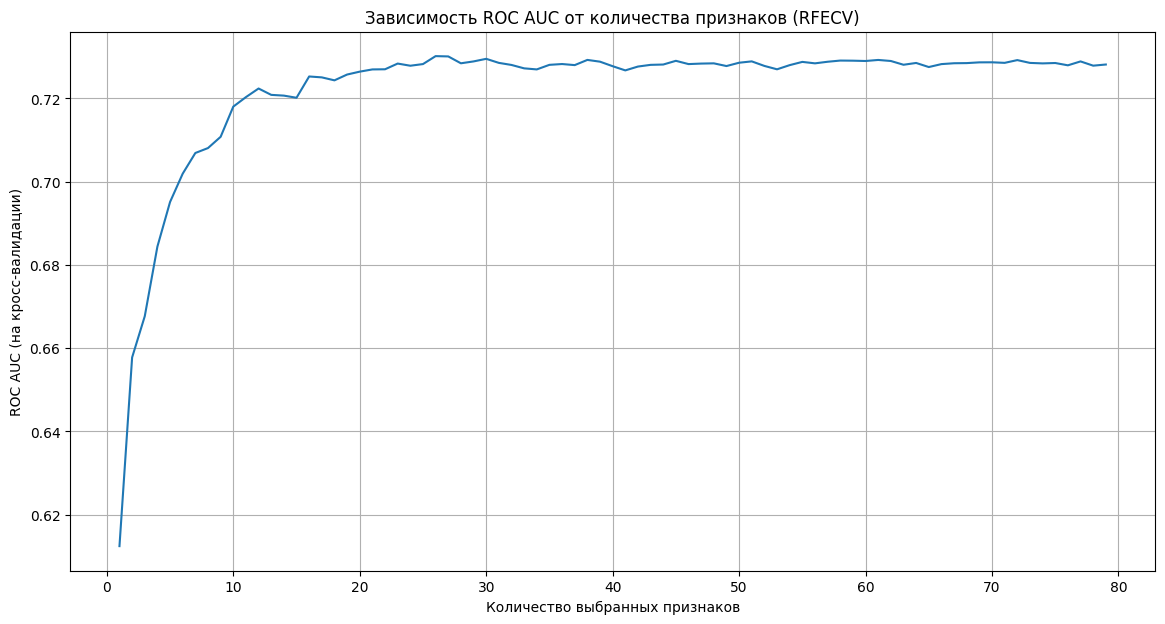

In [34]:
# Использование лучшей модели из OptunaSearchCV как основы
# исключение scale_pos_weight, так как будем использоваться сэмплер
best_params =  optuna_search.best_params_
best_params_cleaned = {k.replace('classifier__', ''): v for k, v in best_params.items()}
if 'scale_pos_weight' in best_params_cleaned:
    del best_params_cleaned['scale_pos_weight']

# Создание базового классификатора для RFECV
estimator = lgbm.LGBMClassifier(random_state=RANDOM_STATE, **best_params_cleaned)

# Создание объекта RFECV
# Он будет "оборачивает" классификатор
rfecv_selector = RFECV(
    estimator=estimator,
    step=1,  # Исключение по одному признаку за раз
    cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',  # Целевая метрика
    n_jobs=-1,
    verbose=1 # Для визуализации прогресса
)

# Построение финального пайплайна
final_pipeline_with_rfecv = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    # Можно добавить сэмплер, если он показал себя хорошо
    # ('sampler', BorderlineSMOTE(random_state=RANDOM_STATE)),
    ('selector', rfecv_selector),
    ('classifier', estimator) # Использование того же классификатора для финального обучения
])

# ЗАПУСК ОБУЧЕНИя
logger.info("Подождите! Идет RFECV-поиск оптимального набора признаков...")
final_pipeline_with_rfecv.fit(X_train_processed, y_train)

# АНАЛИЗ РЕЗУЛЬТАТОВ
rfecv_results = final_pipeline_with_rfecv.named_steps['selector']
print(f"Оптимальное количество признаков: {rfecv_results.n_features_}")

# Визуализация процесса
plt.figure(figsize=(14, 7))
plt.title('Зависимость ROC AUC от количества признаков (RFECV)')
plt.xlabel("Количество выбранных признаков")
plt.ylabel("ROC AUC (на кросс-валидации)")

# В новых версиях sklearn используется cv_results_
scores = rfecv_results.cv_results_['mean_test_score']
plt.plot(range(1, len(scores) + 1), scores)
plt.grid()
plt.show()

In [35]:
print(f"\n{'=' * 68}")
print("📊 РЕЗУЛЬТАТЫ РАСЧЕТОВ МЕТРИК ДЛЯ ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print(f"{'=' * 68}")

# Оценка итоговой модели на тесте
y_pred_proba_rfecv = final_pipeline_with_rfecv.predict_proba(X_test_processed)[:, 1]
roc_auc_rfecv = roc_auc_score(y_test, y_pred_proba_rfecv)
average_precision_rfecv = average_precision_score(y_test, y_pred_proba_rfecv)
print(f"ROC AUC модели с RFECV: {roc_auc_rfecv:.4f}")
print(f"Average Precision модели с RFECV: {average_precision_rfecv:.4f}")


📊 РЕЗУЛЬТАТЫ РАСЧЕТОВ МЕТРИК ДЛЯ ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ:
ROC AUC модели с RFECV: 0.7541
Average Precision модели с RFECV: 0.0718


### Анализ важности признаков улучшенной модели

Исследование, какие признаки оказались наиболее важными для улучшенной модели.

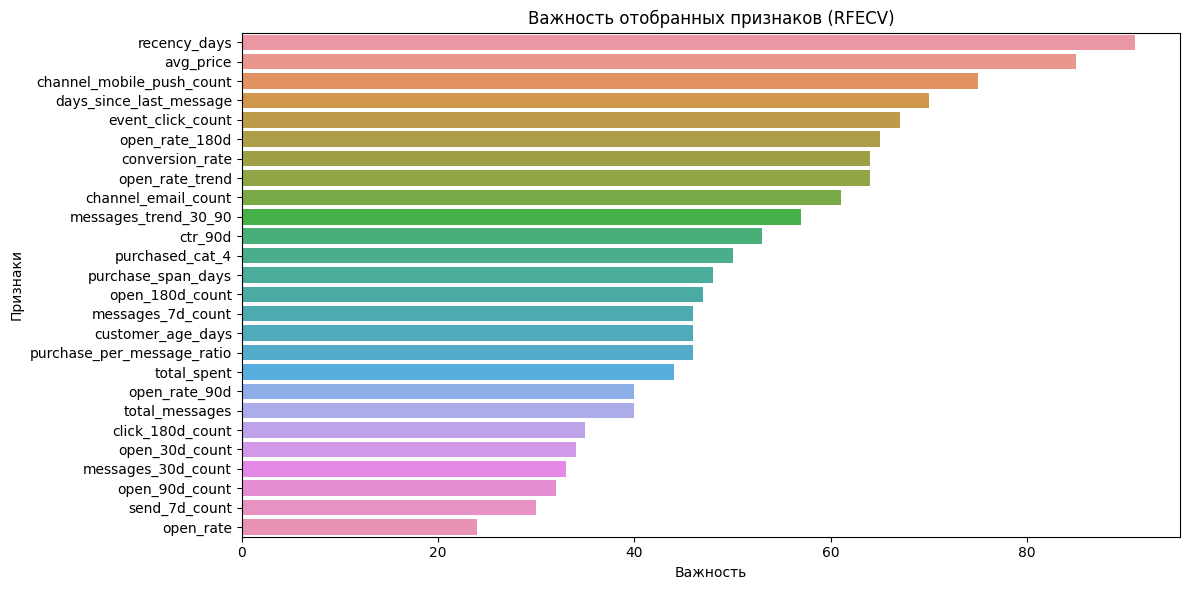

In [36]:
# Получим имена исходных признаков
all_features = X_train_processed.columns

# Булев массив отобранных признаков
mask = rfecv_selector.support_

# Отобранные признаки
selected_features_names = all_features[mask]

# Важности уже обученного внутри RFECV классификатора
importances = rfecv_selector.estimator_.feature_importances_

# Построение DataFrame
importances_df = pd.DataFrame({
    'feature': selected_features_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Визуализация отобранных пизнаков
plt.figure(figsize=(12, 6))
sns.barplot(data=importances_df, x='importance', y='feature')
plt.title('Важность отобранных признаков (RFECV)')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

In [37]:
# Таблица отобранных признаков
importance_table = pd.DataFrame({
    'Признак': selected_features_names,
    'Важность': importances
}).sort_values('Важность', ascending=False).reset_index(drop=True)

display(importance_table)

,Признак,Важность
0,recency_days,91
1,avg_price,85
2,channel_mobile_push_count,75
3,days_since_last_message,70
4,event_click_count,67
5,open_rate_180d,65
6,conversion_rate,64
7,open_rate_trend,64
8,channel_email_count,61
9,messages_trend_30_90,57


### Сравнение базовой и улучшенной моделей

Сравнение производительности базовой и улучшенной моделей с помощью ROC-кривых и Average Precision метрик.

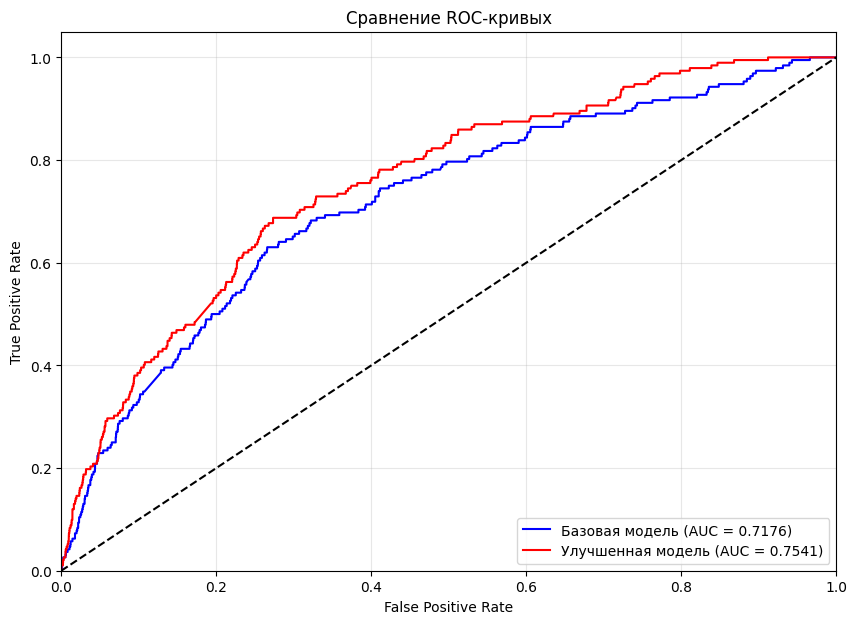

In [38]:
# Построение ROC-кривых
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_pred_proba_rfecv)
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba)

# Визуализация
plt.figure(figsize=(10, 7))
plt.plot(fpr_base, tpr_base, color='blue', label=f'Базовая модель (AUC = {test_roc_auc:.4f})')
plt.plot(fpr_opt, tpr_opt, color='red', label=f'Улучшенная модель (AUC = {roc_auc_rfecv:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [39]:
# Сводная таблица результатов
models_comparison = {
    'Метрика': ['ROC AUC', 'Average Precision Score'],
    'Базовая модель': [round(test_roc_auc, 4), round(test_ap, 4)],
    'Улучшенная модель': [round(roc_auc_rfecv, 4), round(average_precision_rfecv, 4)],
    'Улучшение, %': [round((roc_auc_rfecv - test_roc_auc) / test_roc_auc * 100, 2),
                     round((average_precision_rfecv - test_ap) / test_ap * 100, 2)]
}

comparison_df = pd.DataFrame(models_comparison)
print("\n📊 СРАВНЕНИЕ РЕЗУЛЬТАТОВ МОДЕЛЕЙ:")
display(comparison_df)


📊 СРАВНЕНИЕ РЕЗУЛЬТАТОВ МОДЕЛЕЙ:


,Метрика,Базовая модель,Улучшенная модель,"Улучшение, %"
0,ROC AUC,0.7176,0.7541,5.09
1,Average Precision Score,0.0586,0.0718,22.38


## ВЫВОДЫ ПО ПРОЕКТУ

Промежуточные выводы по проекту изложены в п.1.6, п.3.4, п.4.4.

В ходе исследования была построена модель классификации на основе **LGBMClassifier**, достигшая на тестовой выборке показателя **ROC_AUC=0.7541**, что формально соответствует поставленной цели. Однако, более глубокий анализ с помощью метрики **Average Precision Score (AP)**, которая критически важна для задач с сильным дисбалансом классов, показал для лучшей модели крайне низкое значение **AP=0,0718**.
Это означает, что, несмотря на способность модели к ранжированию клиентов (отделению более вероятных покупателей от менее вероятных), ее практическая ценность для бизнеса ограничена. Для выявления значимой части целевого класса (покупателей) потребуется охватить непропорционально большую долю нецелевой аудитории, что приведет к низкой рентабельности маркетинговых кампаний.

Причиной этого является высокая зашумленность данных и слабый предсказательный сигнал в имеющихся признаках, что подтвердилось неудачными попытками улучшить модель с помощью техник оверсэмплинга. 

**Рекомендации для бизнеса:**

1.  Не внедрять текущую модель в промышленную эксплуатацию для прямого таргетинга.
2.  Сфокусироваться на сборе более качественных данных: запрашивать у клиентов больше информации, собирать данные о поведении на сайте (просмотренные товары, время на странице).
3.  Провести дальнейшее исследование в области Feature Engineering, включая отбор наиболее значимых признаков для снижения уровня шума.